# Import libraries, read data, text normalization process

In [1]:
# Import libraries
import re
import string
import numpy as np
import pandas as pd
from pprint import pprint
import math
from textblob import TextBlob
#from better_profanity import profanity

# Nltk
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\south\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\south\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\south\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\south\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\south\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\south\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\south\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# borrowed from stackoverflow https://stackoverflow.com/a/49146722
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

def remove_unwanted(document):

    # remove URLS 
    document = re.sub(r'http\S+', ' ', document)
    # remove emoji's
    document = remove_emoji(document)
    # remove punctuation
    document = re.sub("[^0-9A-Za-z ]", "" , document)
    # remove double spaces
    document = document.replace('  ',"")
    
    return document.strip()

In [4]:
def lemmatize_text(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', "N": 'n', "V": 'v', "R": 'r'}
    words_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]   
    lemma_list = [wd.lemmatize(tag) for wd, tag in words_tags]
    
    lemmatized_sentence = " ".join(lemma_list)
    return lemmatized_sentence

In [5]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [6]:
data = pd.read_csv("Ukraine_emotions.csv")

exclusive_emotion = ["approval","desire","admiration","love","gratitude","excitement","optimism","joy","amusement","neutral"]
extracted_data = data.loc[~data["Emotion"].isin(exclusive_emotion)].reset_index(drop=True)

extracted_data['tweet']=extracted_data['tweet'].astype(str)

text_corpus = extracted_data

In [7]:
text_corpus

,ids,date,user,replyCount,retweetCount,likeCount,lang,tweet,country,Emotion
0,1.510000e+18,2022-04-08 15:55:45+00:00,berbacurr,0,0,0,en,@Caucasuswar Second strongest military in the ...,Ukraine,curiosity
1,1.510000e+18,2022-04-08 15:55:45+00:00,ChrisJustice01,0,0,0,en,@systemkallops @IAPonomarenko Russia invaded U...,Ukraine,anger
2,1.510000e+18,2022-04-08 15:55:45+00:00,AlexKokcharov,0,0,0,en,War crimes committed by invading #Russia|n for...,Ukraine,fear
3,1.510000e+18,2022-04-08 15:55:43+00:00,m_munck,0,0,0,en,"Learn now,be safe tomorrow:HAM radio is a grea...",Ukraine,caring
4,1.510000e+18,2022-04-08 15:55:43+00:00,XavierRyanXXX,0,0,0,en,The same people who are now the biggest suppor...,Ukraine,curiosity
...,...,...,...,...,...,...,...,...,...,...
829,1.510000e+18,2022-04-08 15:36:21+00:00,ascottgil,0,0,0,en,Double Standard:\n.\nTwenty children are kille...,Ukraine,sadness
830,1.510000e+18,2022-04-08 15:36:19+00:00,irplank1,0,0,0,en,@LibertyHotelB @suddengunter @swl2861 @sentdef...,Ukraine,annoyance
831,1.510000e+18,2022-04-08 15:36:18+00:00,Daniel88422404,0,0,0,en,I just saw on the news where Russia bombed a t...,Ukraine,disappointment
832,1.510000e+18,2022-04-08 15:36:17+00:00,louddermouth,0,0,0,en,@Zak_Bagans Have you ever considered going to ...,Ukraine,curiosity


In [8]:
extracted_data['tweet']= extracted_data['tweet'].astype(str)

text_corpus1 = extracted_data["tweet"].astype(str)

len(text_corpus1)

834

In [9]:
text_corpus1

0      @Caucasuswar Second strongest military in the ...
1      @systemkallops @IAPonomarenko Russia invaded U...
2      War crimes committed by invading #Russia|n for...
3      Learn now,be safe tomorrow:HAM radio is a grea...
4      The same people who are now the biggest suppor...
                             ...                        
829    Double Standard:\n.\nTwenty children are kille...
830    @LibertyHotelB @suddengunter @swl2861 @sentdef...
831    I just saw on the news where Russia bombed a t...
832    @Zak_Bagans Have you ever considered going to ...
833    Just posted on Twitter but I will not RT. \nTh...
Name: tweet, Length: 834, dtype: object

### This section is for expansion purpose

In [10]:
new_corpus = []

for text in text_corpus1:

    clean_text = remove_unwanted(str(text))
    clean_text = ' '.join([w for w in clean_text.split() if len(w)>1])
    clean_text = lemmatize_text(clean_text)
    new_corpus.append(clean_text)

new_corpus = np.array(new_corpus)

In [11]:
new_corpus

array(['Caucasuswar Second strong military in the world or just second strong military in Ukraine',
       'systemkallops IAPonomarenko Russia invade Ukraine Putin be war criminal committing atrocity on innocent civilian Stop Putin Stand with Ukraine',
       'War crime commit by invade Russian force in Ukraine be just horrificThese be just several crime list by Ukraines Human Rights Ombundswoman Denisova',
       'Learn nowbe safe tomorrowHAM radio be great communication tool for Preppers NotificationsRex ManningFridayFeelingfridaymorningDaily Quordle 74JudgeWordle 293 XFridayVibesRepBXYankees Preppers Prepping Ukraine UkraineInvasion',
       'The same people who be now the big supporter of Ukraine be like wut be the holodomor',
       'cocotrolololo8 OwenJones84 Russian arm force need to be expel frm Ukraine by force a they have be defeat and expel from most of Ukraine so farYou disagree You think they shouldve be allow into Kiev to massacre and butcher pple at will Or do believe in

In [12]:
clean_tweet_data = np.array(new_corpus) 
extracted_data["tweet"] = clean_tweet_data
extracted_data.to_csv('paluk_uk_en.csv',index=False)

In [13]:
stop_words = stopwords.words('english')
extended_words = ["hes","ur","le","ta","tf","yo","couldnt","wasnt","along","ago","someone","literally","absolutely","probably","seem",
                  "hasnt","surround","though", "toward","suppose","ya","let","bc","great", "include","havent","joe","word","usa","twitter",
                  "donald","trump","trumps","hey","tomorrow","else","potus","via","ha",'wa', 'palestine', 'israel', 'ukraine', 'russia', 
                  'el', 'ti', 'nous', 'non', '2014', 'shit', 'middle','jordan', 'bien', 'azov', 'sind', 'wir', 'mariupol', 
                  'standwithukraine', 'africa4pal', 'ajapalestine', 'di', 'wird', 'israelis', 'ok', 'pakistan', 'cette', 'might', 
                  'tank', 'hell', 'auch', 'joe10616924', 'sloncycling4p', 'theres', 'begin', 'top', 'oh', 'um', 'comme', 'ich', 'saw', 
                  'head', 'israelpalestine', 'eye', 'sloncycling4pa1', 'ive', '2022', 'pink', 'little', 'daniel85401173', 'jamais', 
                  'zelenskyyua', 'peuple', 'sa', 'occupe', 'wie', 'allah', 'states', 'exactly', 'small',
                  'north', 'together', 'month', 'secblinken', 'billion', 'saoi', 'fr33palestine', 'hananyanaftali', 
                  'mehrmir', 'iam', 'probably', 'gomririam63', 'lapatina', 'hamas', 'buckeyericky', 'ppl', 'saudi', 
                  'britain', 'poland', 'either', 'already', 'traseas7', 'trussliz', 'enough', 'foramericans', 
                  'danielbfreeman3', 'ottoman', 'bc', 'palestineun', 'isreal', 'avimayer', 'liberate', 'bobbyshiskabob', 
                  'april', 'donaldhorwitz5', 'adilg0', 'canadianleb', 'joshpactor', 'samloyal23', 'theundefeated17', 
                  'ymg12345678', 'unhrc', 'free2smile1', 'jordaneesh', 'desuetudine', 'f0xyh0und', 'rookringer',
                  'fox640571', 'somalia', 'alasqa', 'bardot82', 'dublibtarian', 'rieznikg', 'emadmoussa', 'instead', 
                  'qasim', 'elswood3', 'missgrandia', 'besseder1', 'zafarhu58440496', 'lambawor', 'penbird', 'break',
                  'israelandstufff', 'israeli', 'jordan', 'syria', "ukraineworld", 'russian', 'putin', 'ukrainian', 'war', 
                  'weapon', 'ukrainerussia', 'russiaukraine', 'west', 'western', 'thewest', 'nazi', 'biden', 'jet', "american"
                  "obama", 'decide', 'true', 'shouldnt', 'less', 'rt', '2nd', 'second', 'kick', 'new', 'ursula', 'among', 'quickly'
                  'south','person', 'giorgio75964575', 'jennsstoltenberg', 'quickly', 'zelensky', 'ukraineyou', 'add', 'finally', 'indian', 
                  'moment', 'actually', 'krylenko', 'catwomen', 'felt', 'stick', 'man', 'canada', 'damn', 'white', 'hundred', 'boris','likely', 
                  'increase', 'inu', 'neither', 'certainly', 'share', 'current', 'listen', 'johnson', 'south', 'half', 'later', 'partly', 
                  'glblctzn', 'disclosetv', 'paulmasonnews', 'u', 'na']
stop_words.extend(extended_words)

In [14]:
tokenizer = RegexpTokenizer(r'\w+')

tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=stop_words,
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize,
                        max_features=500,
                        encoding='utf-8')

train_data = tfidf.fit_transform(new_corpus)


C:\Users\south\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
indices = np.argsort(tfidf.idf_)[::-1]
features = tfidf.get_feature_names_out()
top_n = 500
top_features = [features[i] for i in indices[:top_n]]
print (top_features)

['asset', 'narrative', 'discover', 'jensstoltenberg', 'fuel', 'obama', 'nuke', 'courage', 'course', 'unbelievable', 'carry', 'inflation', 'industry', 'student', 'imagine', 'ill', 'hunter', 'hospital', 'change', 'cnn', 'carnage', 'soar', 'base', 'baby', 'sacrifice', 'ruin', 'angry', 'rescue', 'assist', 'region', 'group', 'serious', 'responsible', 'issue', 'kremlin', 'order', 'liar', 'loss', 'love', 'refuse', 'rape', 'majority', 'pass', 'parliament', 'others', 'german', 'land', 'friday', 'follow', '51', 'abuse', 'account', 'afraid', 'area', 'ashamed', 'attempt', 'attention', 'awful', 'battalion', 'bill', 'bombing', 'case', 'communist', 'complete', 'control', 'corrupt', 'cry', 'defence', 'defense', 'deserve', 'disgust', 'entire', 'escalation', 'evacuate', 'existence', 'fake', 'fire', 'fly', 'social', '10', 'turn', 'ukrainewar', 'unfortunately', 'whole', 'tragedy', 'volunteer', 'yeah', 'tear', 'strong', 'hurt', 'ignore', 'lets', 'important', 'horrible', 'information', 'holocaust', 'lack', 

# Create WordCloud

In [16]:
#convert object to string
import string
string_terms=str(top_features)
string_terms = ' '.join(top_features).lower()
REPLACE_APS = re.compile(r"[\']")
string_terms = REPLACE_APS .sub("", string_terms)
print(string_terms)
print(type(string_terms))

asset narrative discover jensstoltenberg fuel obama nuke courage course unbelievable carry inflation industry student imagine ill hunter hospital change cnn carnage soar base baby sacrifice ruin angry rescue assist region group serious responsible issue kremlin order liar loss love refuse rape majority pass parliament others german land friday follow 51 abuse account afraid area ashamed attempt attention awful battalion bill bombing case communist complete control corrupt cry defence defense deserve disgust entire escalation evacuate existence fake fire fly social 10 turn ukrainewar unfortunately whole tragedy volunteer yeah tear strong hurt ignore lets important horrible information holocaust lack late launch treat stuff threat hawleymo market member mind mingalabawar miss number official olafscholz olliecarroll term owenjones84 pain party local full hand clear able accept affect air write worry worried wonder bidens buy buying whatever check community georgegalloway condemn create de

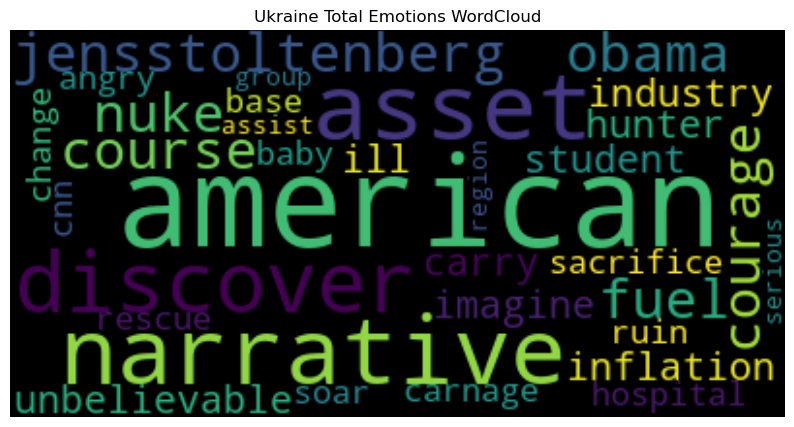

In [17]:
#for plotting images & adjusting colors
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import wordcloud
from wordcloud import WordCloud,STOPWORDS

## CREATE THE WORDCLOUD
# setting stopwords
stop_words = set(STOPWORDS)

# generating a wordcloud
wordcloud = WordCloud(stopwords=stop_words, max_font_size=65, 
                      min_font_size=9, collocations=True).generate(string_terms)

# show
plt.figure(figsize=[10,10])
plt.axis("off")
plt.title("Ukraine Total Emotions WordCloud")

# store to file
plt.imshow(wordcloud, interpolation='bilinear')

In [18]:
plt.savefig("UkraineWordCloud.png", format="png") 

<Figure size 640x480 with 0 Axes>